## Librery installation

In [25]:
# Intallation  

! pip install pandas
! pip install matplotlib
! pip install torch
! pip install seaborn   

! pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


All proteomic data collected so far. MGUS, sMM and MM data

NN using sklearn and torch

Initial data shape: (2995, 44)
Transposed data shape: (44, 2995)
Labels length: 44
Features shape: (44, 2995)
X shape: torch.Size([44, 2995])
y shape: torch.Size([44])
Epoch [1/1000], Loss: 1.0686, Validation Accuracy: 44.44%
Epoch [2/1000], Loss: 0.9567, Validation Accuracy: 33.33%
Epoch [3/1000], Loss: 0.8644, Validation Accuracy: 44.44%
Epoch [4/1000], Loss: 0.6977, Validation Accuracy: 44.44%
Epoch [5/1000], Loss: 0.6719, Validation Accuracy: 44.44%
Epoch [6/1000], Loss: 0.6194, Validation Accuracy: 44.44%
Epoch [7/1000], Loss: 0.5148, Validation Accuracy: 44.44%
Epoch [8/1000], Loss: 0.4780, Validation Accuracy: 55.56%
Epoch [9/1000], Loss: 0.4437, Validation Accuracy: 55.56%
Epoch [10/1000], Loss: 0.4250, Validation Accuracy: 55.56%
Epoch [11/1000], Loss: 0.3674, Validation Accuracy: 55.56%
Epoch [12/1000], Loss: 0.3374, Validation Accuracy: 55.56%
Epoch [13/1000], Loss: 0.2724, Validation Accuracy: 55.56%
Epoch [14/1000], Loss: 0.2476, Validation Accuracy: 55.56%
Epoch [15/1000]

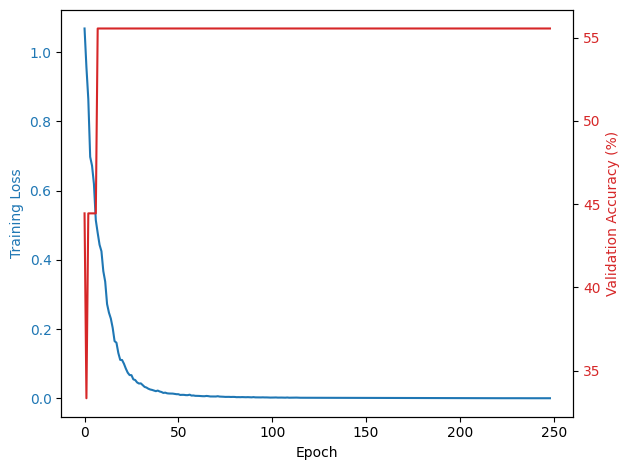

Final Test Accuracy: 55.56%


In [26]:
import pandas as pd
import numpy as np
import matplotlib
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Load the data
file_path = 'C:/Users/a121160/OneDrive - Eviden/Documents/Proyecto/ELMUMY/WPs/WP4/DATA/InputNN_all.xlsx'
data = pd.read_excel(file_path, decimal=',', header=None)

# Print the initial shape of the data
print("Initial data shape:", data.shape)

# Transpose the data to have patients as rows and genes as columns
data = data.T

# Print the shape after transposing
print("Transposed data shape:", data.shape)

# Generate labels based on the known structure
# 16 MGUS (label 0), 12 sMM (label 1), 15 MM (label 2)
labels = [0] * 16 + [1] * 12 + [2] * 15

# Ensure the labels length matches the number of rows in the transposed data
print("Labels length:", len(labels))

# The new features are the transposed data
features = data.astype(float)

# Print the shape of the features
print("Features shape:", features.shape)

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Convert to PyTorch tensors
X = torch.tensor(scaled_features, dtype=torch.float32)
y = torch.tensor(labels, dtype=torch.long)

# Ensure that the shapes match correctly
print("X shape:", X.shape)
print("y shape:", y.shape)

# Define input dimension
input_dim = X.shape[1]

# Split data into training and testing sets
# Training Set: Used to train the model. The model learns patterns and relationships from this subset.
# Testing Set: Used to evaluate the model. This subset is not seen by the model during training 
# and provides an unbiased evaluation of the model's performance on unseen data.
#random_state: This parameter controls the shuffling applied to the data before splitting.
# random_state=44 ensures that the splitting of the data is reproducible. 
# Using the same random_state value will produce the same split every time you run the code.


# X_train: The training subset of the input features.
# X_test: The testing subset of the input features.
# y_train: The training subset of the target labels.
# y_test: The testing subset of the target labels.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

# The random_state parameter in the train_test_split function is used to ensure reproducibility of your results. 
# By setting a random_state, you can guarantee that the data is split in the same way each time you run the code. 
# The specific value you choose for random_state does not affect the quality or appropriateness of the split; it is simply a seed for the random number generato


# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Define a neural network model with dropout
class SimpleNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(64, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# Initialize the model, loss function, and optimizer
output_dim = 3  # Number of classes
model = SimpleNN(input_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training function with early stopping and loss/accuracy tracking
def train(model, train_loader, criterion, optimizer, epochs=1000, patience=10):
    model.train()
    min_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_accuracies = []
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        
        val_accuracy = evaluate(model, test_loader)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
        
        # Early stopping
        if avg_loss < min_loss:
            min_loss = avg_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping")
                break
    
    return train_losses, val_accuracies

# Evaluation function
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Train the model and track losses and accuracies
train_losses, val_accuracies = train(model, train_loader, criterion, optimizer, epochs=1000, patience=10)

# Plot training loss and validation accuracy
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss', color=color)
ax1.plot(train_losses, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Validation Accuracy (%)', color=color)
ax2.plot(val_accuracies, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

# Final evaluation on the test set
final_accuracy = evaluate(model, test_loader)
print(f"Final Test Accuracy: {final_accuracy:.2f}%")

## Random Forest

In [27]:
# ! pip install sklearn 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initialize the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {accuracy_rf:.4f}')


Random Forest Accuracy: 0.5556


## Support Vector Machine : Multiclass 

In [28]:
from sklearn.svm import SVC

# Initialize the model
svm_model = SVC(kernel='linear', C=1, random_state=42)

# Train the model
svm_model.fit(X_train, y_train)

# Predict on test set
y_pred_svm = svm_model.predict(X_test)

# Evaluate the model
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f'SVM Accuracy: {accuracy_svm:.4f}')


SVM Accuracy: 0.5556


## Gradient Boosting Classsifer

In [29]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize the model
gbm_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

# Train the model
gbm_model.fit(X_train, y_train)

# Predict on test set
y_pred_gbm = gbm_model.predict(X_test)

# Evaluate the model
accuracy_gbm = accuracy_score(y_test, y_pred_gbm)
print(f'Gradient Boosting Accuracy: {accuracy_gbm:.4f}')


Gradient Boosting Accuracy: 0.2222


## Logistic Regression

In [30]:
from sklearn.linear_model import LogisticRegression

# Initialize the model
logreg_model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
logreg_model.fit(X_train, y_train)

# Predict on test set
y_pred_logreg = logreg_model.predict(X_test)

# Evaluate the model
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
print(f'Logistic Regression Accuracy: {accuracy_logreg:.4f}')


Logistic Regression Accuracy: 0.6667


## KNN

In [31]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize the model
knn_model = KNeighborsClassifier(n_neighbors=5)

# Train the model
knn_model.fit(X_train, y_train)

# Predict on test set
y_pred_knn = knn_model.predict(X_test)

# Evaluate the model
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f'KNN Accuracy: {accuracy_knn:.4f}')


KNN Accuracy: 0.5556


In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 1. Data Preparation
# Origina data in a CSV format
file_path = 'C:/Users/a121160/OneDrive - Eviden/Documents/Proyecto/ELMUMY/WPs/WP4/DATA/InputNN_all.xlsx'
data = pd.read_excel(file_path, decimal=',', header=None)
print(data.shape)

# Extract features and labels (proteomic data with 2995 features)
X = data.iloc[:, :2995].values
labels = ['MGUS']*16 + ['sMM']*16 + ['MM']*12
y = np.array([0]*16 + [1]*16 + [2]*12)

# Normalize the data
#scaler = StandardScaler()
#X = scaler.fit_transform(X)

# Convert to PyTorch tensors
# Transpose the input data
X = X.T

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 2. Define the Neural Network
class ProteomicNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ProteomicNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

input_size = X_train.shape[1]
hidden_size = 128
output_size = len(np.unique(y))  # Number of classes

model = ProteomicNN(input_size, hidden_size, output_size)

# 3. Training the Model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20
for epoch in range(num_epochs):
    for X_batch, y_batch in train_loader:
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 4. Evaluation
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    y_pred = []
    y_true = []
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.numpy())
        y_true.extend(y_batch.numpy())

    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy:.4f}')


(2995, 44)
Epoch [1/20], Loss: 0.4083
Epoch [2/20], Loss: 0.3727
Epoch [3/20], Loss: 0.1584
Epoch [4/20], Loss: 0.0059
Epoch [5/20], Loss: 0.0045
Epoch [6/20], Loss: 0.0007
Epoch [7/20], Loss: 0.0000
Epoch [8/20], Loss: 0.0002
Epoch [9/20], Loss: 0.0000
Epoch [10/20], Loss: 0.0000
Epoch [11/20], Loss: 0.0016
Epoch [12/20], Loss: 0.0000
Epoch [13/20], Loss: 0.0002
Epoch [14/20], Loss: 0.0001
Epoch [15/20], Loss: 0.0002
Epoch [16/20], Loss: 0.0002
Epoch [17/20], Loss: 0.0002
Epoch [18/20], Loss: 0.0001
Epoch [19/20], Loss: 0.0000
Epoch [20/20], Loss: 0.0005
Accuracy: 0.5556


Defaulting to user installation because normal site-packages is not writeable
(2995, 44)
Epoch [1/50], Loss: 1.1773
Epoch [2/50], Loss: 1.0053
Epoch [3/50], Loss: 0.8178
Epoch [4/50], Loss: 0.7423
Epoch [5/50], Loss: 0.6254
Epoch [6/50], Loss: 0.5455
Epoch [7/50], Loss: 0.4648
Epoch [8/50], Loss: 0.4070
Epoch [9/50], Loss: 0.3592
Epoch [10/50], Loss: 0.2993
Epoch [11/50], Loss: 0.2778
Epoch [12/50], Loss: 0.2726
Epoch [13/50], Loss: 0.2571
Epoch [14/50], Loss: 0.2578
Epoch [15/50], Loss: 0.1756
Epoch [16/50], Loss: 0.2082
Epoch [17/50], Loss: 0.1444
Epoch [18/50], Loss: 0.1112
Epoch [19/50], Loss: 0.1002
Epoch [20/50], Loss: 0.0753
Epoch [21/50], Loss: 0.0669
Epoch [22/50], Loss: 0.0597
Epoch [23/50], Loss: 0.0695
Epoch [24/50], Loss: 0.0432
Epoch [25/50], Loss: 0.0394
Epoch [26/50], Loss: 0.0399
Epoch [27/50], Loss: 0.0649
Epoch [28/50], Loss: 0.0425
Epoch [29/50], Loss: 0.0466
Epoch [30/50], Loss: 0.0613
Epoch [31/50], Loss: 0.0098
Epoch [32/50], Loss: 0.0291
Epoch [33/50], Loss: 0.0

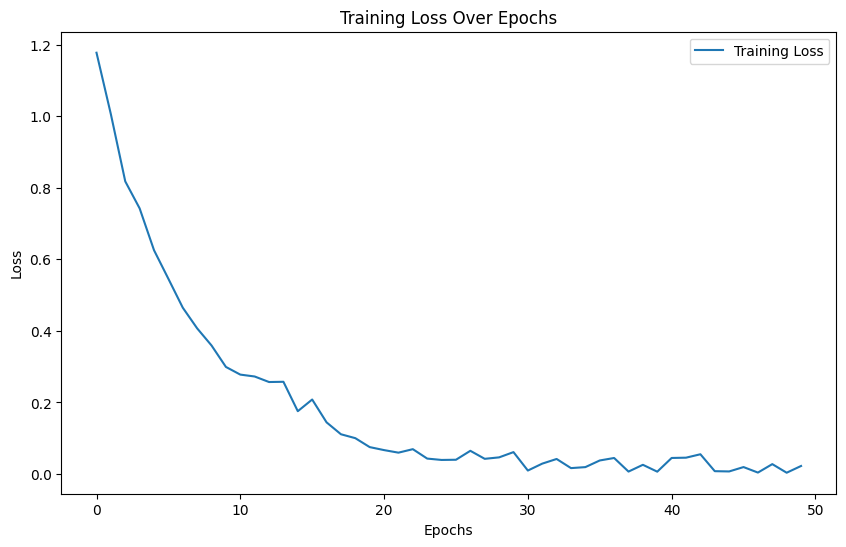

Accuracy: 0.7778


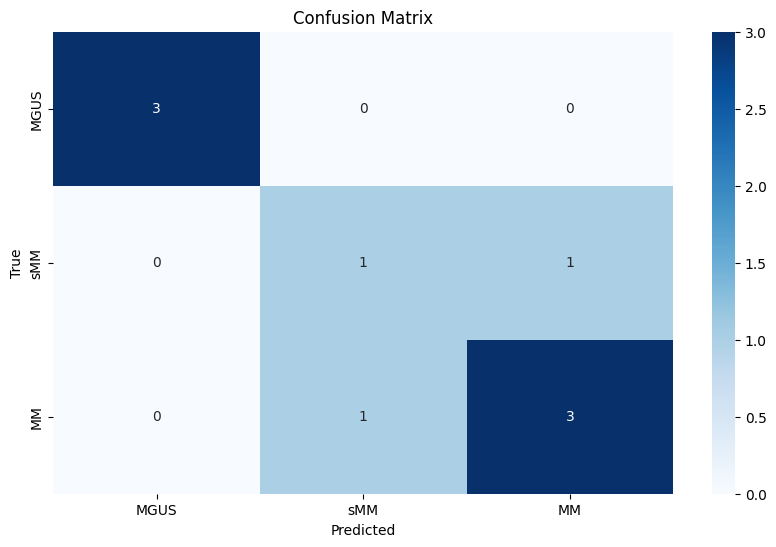

In [33]:
! pip install seaborn

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Data Preparation
file_path = 'C:/Users/a121160/OneDrive - Eviden/Documents/Proyecto/ELMUMY/WPs/WP4/DATA/InputNN_all.xlsx'
data = pd.read_excel(file_path, decimal=',', header=None)
print(data.shape)

# Extract features and labels
X = data.iloc[:, :3000].values
labels = ['MGUS']*16 + ['sMM']*12 + ['MM']*16
y = np.array([0]*16 + [1]*12 + [2]*16)

# Normalize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)
# Transpose the input data
X = X.T 
# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# 2. Define the Neural Network
class ProteomicNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ProteomicNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

input_size = X_train.shape[1]
hidden_size = 128
output_size = len(np.unique(y))

model = ProteomicNN(input_size, hidden_size, output_size)

# 3. Training the Model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    losses.append(avg_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

# Plotting the training loss
plt.figure(figsize=(10, 6))
plt.plot(losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

# 4. Evaluation
model.eval()
with torch.no_grad():
    y_pred = []
    y_true = []
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.numpy())
        y_true.extend(y_batch.numpy())

    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy:.4f}')
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['MGUS', 'sMM', 'MM'], yticklabels=['MGUS', 'sMM', 'MM'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


Confusion matrix for the different ML algoritms

Plotting 

Confusion matrix

Installing and importing libraries

In [34]:
! pip install scikit-learn
! pip install matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_decision_boundary(model, X, y, title):
    # Only works for 2D data
    if X.shape[1] != 2:
        print("Decision boundary plot only works for 2D data")
        return
    
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.Paired)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', s=50, cmap=plt.cm.Paired)
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


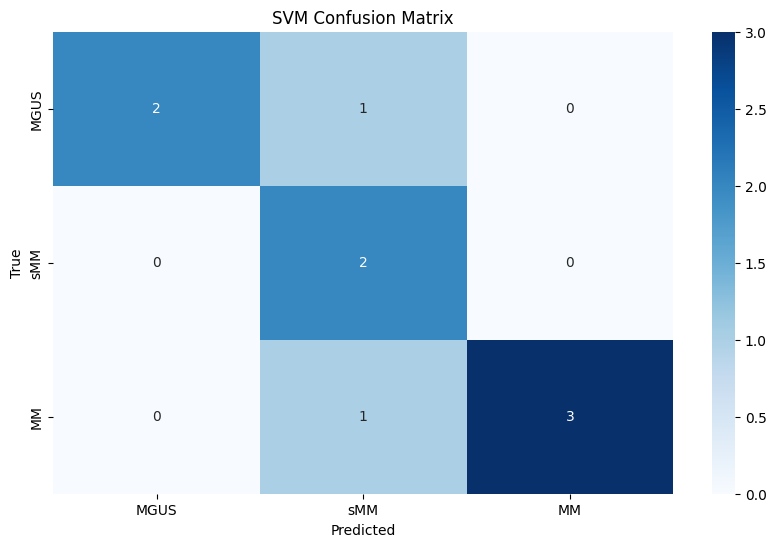

Decision boundary plot only works for 2D data


In [41]:
from sklearn.svm import SVC
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
def plot_conf_matrix(model, X, y, title):
    y_pred = model.predict(X)
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['MGUS', 'sMM', 'MM'], yticklabels=['MGUS', 'sMM', 'MM'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()
# Plot confusion matrix
plot_conf_matrix(svm_model, X_test, y_test, 'SVM Confusion Matrix')

# Plot decision boundary (if applicable)
plot_decision_boundary(svm_model, X_train.numpy(), y_train.numpy(), 'SVM Decision Boundary')


Logistic Regression Accuracy: 0.8889


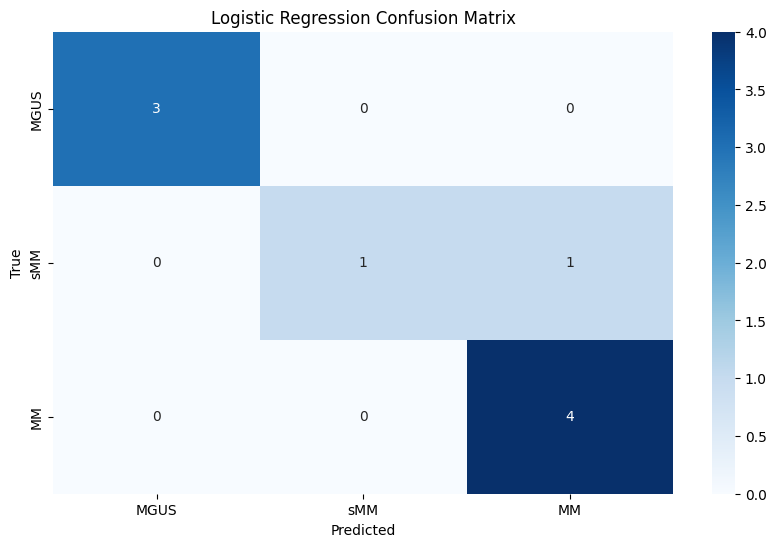

In [36]:
from sklearn.linear_model import LogisticRegression

# Initialize the model
logreg_model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
logreg_model.fit(X_train, y_train)

# Predict on test set
y_pred_logreg = logreg_model.predict(X_test)

# Evaluate the model
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
print(f'Logistic Regression Accuracy: {accuracy_logreg:.4f}')

# Plot confusion matrix
plot_conf_matrix(logreg_model, X_test, y_test, 'Logistic Regression Confusion Matrix')

# Plot decision boundary (if applicable)
# plot_decision_boundary(logreg_model, X_train.numpy(), y_train.numpy(), 'Logistic Regression Decision Boundary')


KNN Accuracy: 0.7778


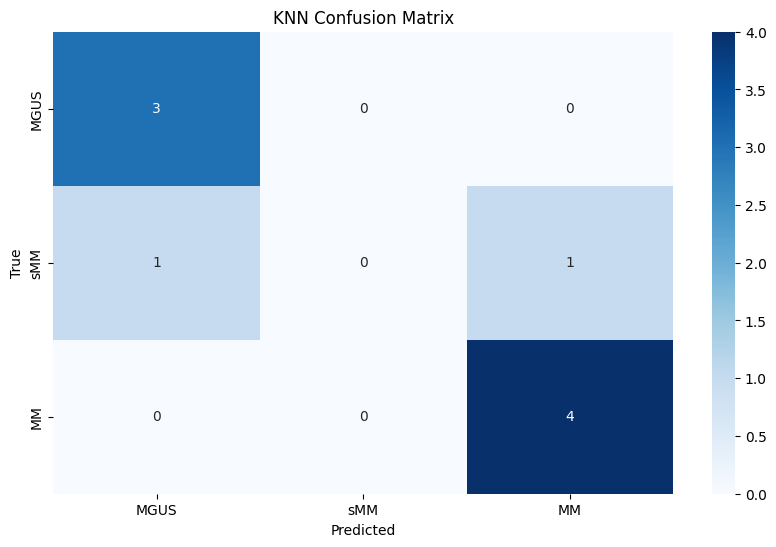

Decision boundary plot only works for 2D data


In [40]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize the model
knn_model = KNeighborsClassifier(n_neighbors=5)

# Train the model
knn_model.fit(X_train, y_train)

# Predict on test set
y_pred_knn = knn_model.predict(X_test)

# Evaluate the model
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f'KNN Accuracy: {accuracy_knn:.4f}')

# Plot confusion matrix
plot_conf_matrix(knn_model, X_test, y_test, 'KNN Confusion Matrix')

# Plot decision boundary (if applicable)
plot_decision_boundary(knn_model, X_train.numpy(), y_train.numpy(), 'KNN Decision Boundary')


Random Forest Accuracy: 0.5556


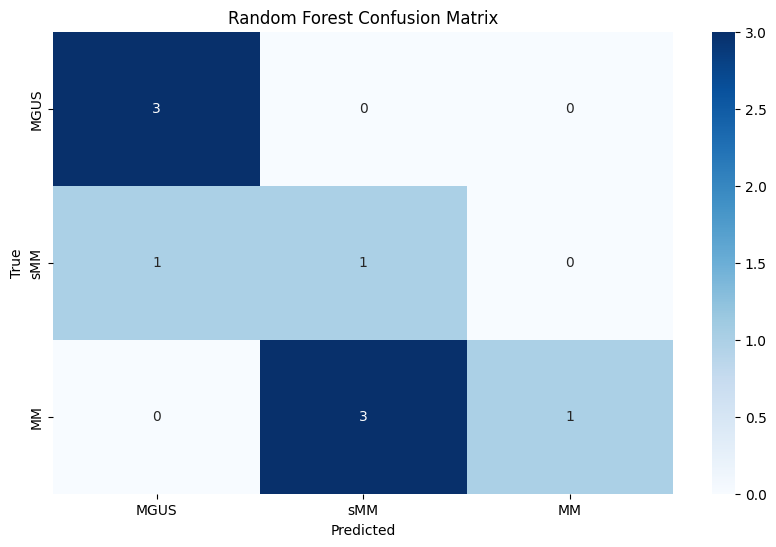

In [38]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {accuracy_rf:.4f}')

# Plot confusion matrix
plot_conf_matrix(rf_model, X_test, y_test, 'Random Forest Confusion Matrix')

# Plot decision boundary (if applicable)
# plot_decision_boundary(rf_model, X_train.numpy(), y_train.numpy(), 'Random Forest Decision Boundary')


Gradient Boosting Accuracy: 0.5556


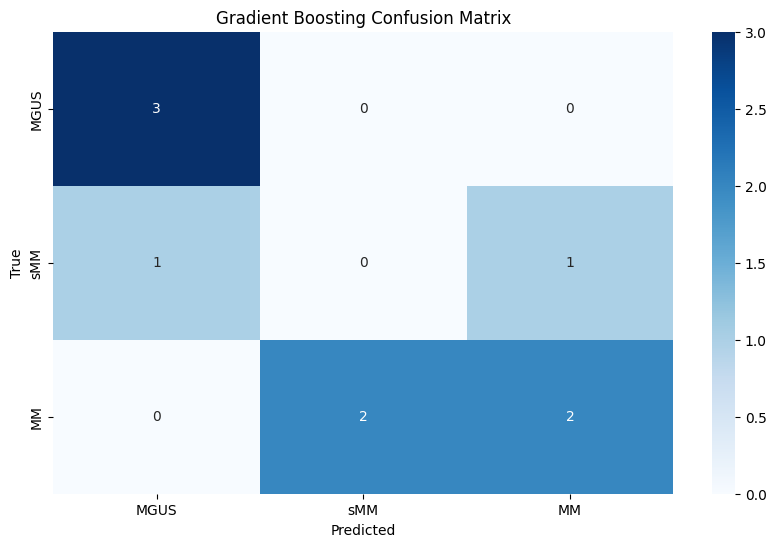

In [39]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize the model
gbm_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

# Train the model
gbm_model.fit(X_train, y_train)

# Predict on test set
y_pred_gbm = gbm_model.predict(X_test)

# Evaluate the model
accuracy_gbm = accuracy_score(y_test, y_pred_gbm)
print(f'Gradient Boosting Accuracy: {accuracy_gbm:.4f}')

# Plot confusion matrix
plot_conf_matrix(gbm_model, X_test, y_test, 'Gradient Boosting Confusion Matrix')

# Plot decision boundary (if applicable)
# plot_decision_boundary(gbm_model, X_train.numpy(), y_train.numpy(), 'Gradient Boosting Decision Boundary')


In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initialize the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {accuracy_rf:.4f}')

Random Forest Accuracy: 0.5556


In [42]:
from sklearn.svm import SVC

# Initialize the model
svm_model = SVC(kernel='linear', C=1, random_state=42)

# Train the model
svm_model.fit(X_train, y_train)

# Predict on test set
y_pred_svm = svm_model.predict(X_test)

# Evaluate the model
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f'SVM Accuracy: {accuracy_svm:.4f}')


SVM Accuracy: 0.7778


In [ ]:
from sklearn.linear_model import LogisticRegression

# Initialize the model
logreg_model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
logreg_model.fit(X_train, y_train)

# Predict on test set
y_pred_logreg = logreg_model.predict(X_test)

# Evaluate the model
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
print(f'Logistic Regression Accuracy: {accuracy_logreg:.4f}')


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize the model
gbm_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

# Train the model
gbm_model.fit(X_train, y_train)

# Predict on test set
y_pred_gbm = gbm_model.predict(X_test)

# Evaluate the model
accuracy_gbm = accuracy_score(y_test, y_pred_gbm)
print(f'Gradient Boosting Accuracy: {accuracy_gbm:.4f}')


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize the model
knn_model = KNeighborsClassifier(n_neighbors=5)

# Train the model
knn_model.fit(X_train, y_train)

# Predict on test set
y_pred_knn = knn_model.predict(X_test)

# Evaluate the model
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f'KNN Accuracy: {accuracy_knn:.4f}')
